## MPAA rating prediction

In [302]:
import pandas as pd
import numpy as np
import warnings
import re
import pickle
import seaborn as sns

%matplotlib inline
warnings.filterwarnings('ignore')

Import dataset :: using the rotten tomatoes dataset

In [303]:
dataset_df = pd.read_csv( './rtt_dataset/all_movie.csv' )
dataset_df = dataset_df[['Title', 'Rating', 'Description']]
dataset_df.columns = dataset_df.columns.str.strip()
dataset_df.head(4)

,Title,Rating,Description
0,The Mummy: Tomb of the Dragon Emperor,PG-13,The Fast and the Furious director Rob Cohen co...
1,The Masked Saint,PG-13,The journey of a professional wrestler who bec...
2,Spy Hard,PG-13,"Dead pan Leslie Nielsen stars as Dick Steele, ..."
3,Der Baader Meinhof Komplex (The Baader Meinhof...,R,Director Uli Edel teams with screenwriter Bern...


In [304]:
# finding unique mpaa rating in the dataset
dataset_df['Rating'].unique()

array(['PG-13 ', 'PG-13', 'R ', 'NR', 'PG', 'G', 'PG ', 'R', 'G ', 'NR ',
       'NC17', 'NC17 '], dtype=object)

In [305]:
# clean mpaa ratings
mpaa_fix = {
    'PG-13 ' : 'PG-13',
    'R ' : 'R',
    'PG ': 'PG',
    'G ' : 'G',
    'NR ': 'NR',
    'NC17 ': 'NC17'
}
for i, rating in dataset_df['Rating'].iteritems():
    if rating in mpaa_fix.keys():
        fix_val = mpaa_fix.get(rating)
        dataset_df.iloc[i]['Rating'] = fix_val
dataset_df['Rating'].unique()

array(['PG-13', 'R', 'NR', 'PG', 'G', 'NC17'], dtype=object)

In [306]:
# Clean the movie description
def clean_description( text_str ):
    text = re.sub('[^a-zA-Z]',  ' ', text_str)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

cleaned_desc = []
for i, description in dataset_df['Description'].iteritems():
    cleaned_desc.append( clean_description( str(description) ) )

dataset_df['cleanedDescr'] = cleaned_desc
dataset_df.head(4)

,Title,Rating,Description,cleanedDescr
0,The Mummy: Tomb of the Dragon Emperor,PG-13,The Fast and the Furious director Rob Cohen co...,The Fast and the Furious director Rob Cohen co...
1,The Masked Saint,PG-13,The journey of a professional wrestler who bec...,The journey of professional wrestler who becom...
2,Spy Hard,PG-13,"Dead pan Leslie Nielsen stars as Dick Steele, ...",Dead pan Leslie Nielsen stars as Dick Steele a...
3,Der Baader Meinhof Komplex (The Baader Meinhof...,R,Director Uli Edel teams with screenwriter Bern...,Director Uli Edel teams with screenwriter Bern...


In [307]:
pickle.dump(dataset_df, open('./data/dataset_df_cleaned_n_sample_exceptNC17BiD.pkl', 'wb'))

## Data Distribution

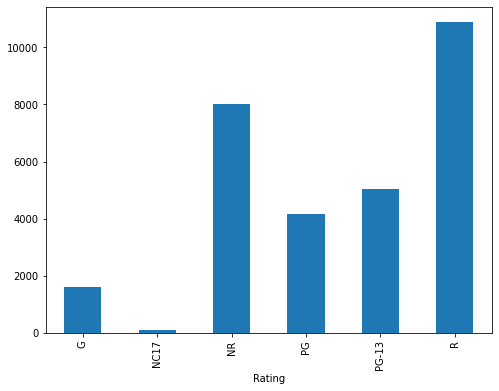

In [308]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
dataset_df.groupby('Rating')['cleanedDescr'].count().plot.bar(ylim=0)
plt.show()

In [309]:
## drop G, NC-17
dataset_df = dataset_df[dataset_df.Rating != 'NC17']

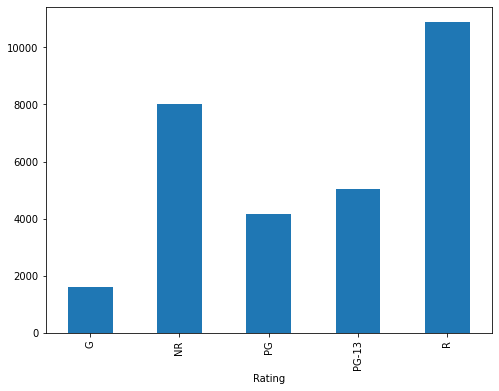

In [310]:
fig = plt.figure(figsize=(8,6))
dataset_df.groupby('Rating')['cleanedDescr'].count().plot.bar(ylim=0)
plt.show()

## Use same amount of labels

In [311]:
PG_count = dataset_df[dataset_df.Rating == 'G'].shape
PG_count

(1606, 4)

In [312]:
dataset_df = dataset_df.sample(frac=1).groupby('Rating').head(1606)
dataset_df

,Title,Rating,Description,cleanedDescr
24516,The Hard Word,R,Three brothers who would argue that crime does...,Three brothers who would argue that crime does...
14755,The Exorcism of Emily Rose,PG-13,"In an extremely rare decision, the Catholic Ch...",In an extremely rare decision the Catholic Chu...
6463,Marnie,PG,One year after she appeared as Melanie Daniels...,One year after she appeared as Melanie Daniels...
28560,Chipmunk Adventure,G,"Join Alvin, Simon, and Theodore as they gradua...",Join Alvin Simon and Theodore as they graduate...
24364,The Sadist,R,Three teachers find themselves terrorized by a...,Three teachers find themselves terrorized by c...
...,...,...,...,...
20471,Calle 54,G,Filmmaker Fernando Trueba was introduced to La...,Filmmaker Fernando Trueba was introduced to La...
2003,For Whom the Bell Tolls,G,"Based on the novel by Ernest Hemingway, this r...",Based on the novel by Ernest Hemingway this ro...
7023,Little Women,G,Of the many film versions of Louisa May Alcott...,Of the many film versions of Louisa May Alcott...
3542,Quest For Camelot,G,Warner Bros. twists the Camelot tale -- adding...,Warner Bros twists the Camelot tale adding fem...


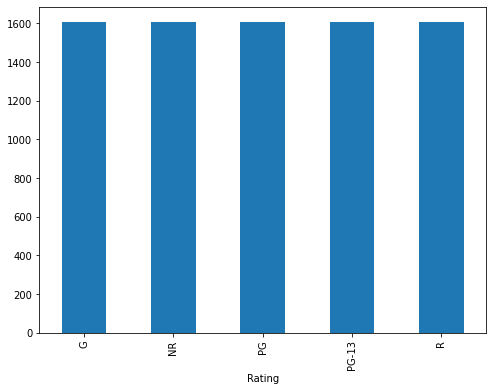

In [313]:
fig = plt.figure(figsize=(8,6))
dataset_df.groupby('Rating')['cleanedDescr'].count().plot.bar(ylim=0)
plt.show()

## Training model

In [363]:
training_df = pickle.load( open('./data/dataset_df_cleaned_n_sample_exceptNC17BiD.pkl', 'rb') )

In [364]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, LSTM, Embedding, GlobalMaxPooling1D, Bidirectional, Dropout

In [365]:
_y = training_df['Rating']
encoder = LabelEncoder()
Y = encoder.fit_transform(_y)
Y

array([4, 4, 4, ..., 5, 4, 4])

In [366]:
X = training_df['cleanedDescr']
X

0        The Fast and the Furious director Rob Cohen co...
1        The journey of professional wrestler who becom...
2        Dead pan Leslie Nielsen stars as Dick Steele a...
3        Director Uli Edel teams with screenwriter Bern...
4        One of cluster of late films about the Vietnam...
                               ...                        
29805    Filmed at least nine times over the last nine ...
29806    Fred MacMurray stars in this Walt Disney comed...
29807    A resident of rd century Earth becomes involve...
29808    Supernova chronicles the search and rescue pat...
29809    For years there have been documented cases of ...
Name: cleanedDescr, Length: 29810, dtype: object

In [367]:
description_lengths = []
for i, description in training_df['cleanedDescr'].iteritems():
    description_lengths.append( len(description) )
max_description_length = np.mean( description_lengths )
max_description_length

729.3683998658169

## Train, test split

In [368]:
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.3, random_state=40 )

In [369]:
Y_train = to_categorical(Y_train)
Y_test  = to_categorical(Y_test)

In [370]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

In [371]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test  = tokenizer.texts_to_sequences(X_test)

In [372]:
vocabulary_size = len(tokenizer.word_index) + 1
vocabulary_size

56359

In [373]:
max_description_length = 1000
maxlen =  400 # Only concider first 400 words of each description

X_train = pad_sequences( X_train, maxlen=maxlen )
X_test  = pad_sequences( X_test, maxlen=maxlen )

## Use GloVe : Global Vectors for Word Representation
https://nlp.stanford.edu/projects/glove/

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space. 

In [374]:
glove_file = open('./glove.6B/glove.6B.100d.txt', encoding='utf8')

In [375]:
embedd_dictionary = dict()
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dims = np.asarray(records[1:], dtype='float32')
    embedd_dictionary[word] = vector_dims

glove_file.close()

In [376]:
embedd_matrix = np.zeros((vocabulary_size, 100))
for word, index in tokenizer.word_index.items():
    embedd_vector = embedd_dictionary.get(word)
    if embedd_vector is not None:
        embedd_matrix[index] = embedd_vector
embedd_matrix.shape

(56359, 100)

In [377]:
output_dim = embedd_matrix.shape[1]
output_dim

100

## Build the NN Model

In [396]:
model = Sequential()
model.add(Embedding(input_dim=vocabulary_size, output_dim=output_dim, weights=[embedd_matrix], trainable=False))
model.add( Bidirectional(LSTM(units=128, return_sequences=True)) )
model.add( Bidirectional(LSTM(units=64)) )

# model.add( Bidirectional(LSTM(units=64)) )
# model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0) )
# model.add(Dense(64, activation='relu'))
# model.add(Dense(6, activation='softmax'))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, None, 100)         5635900   
_________________________________________________________________
bidirectional_19 (Bidirectio (None, None, 256)         234496    
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 128)               164352    
_________________________________________________________________
dense_46 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 6)                 390       
Total params: 6,043,394
Trainable params: 407,494
Non-trainable params: 5,635,900
_____________________________________

In [397]:
import keras
callback = [
    #keras.callbacks.EarlyStopping(patience=2),
    keras.callbacks.ModelCheckpoint(filepath='./data/checkpoint/model.{epoch:02d}-{val_loss:.2f}.h5'),
    keras.callbacks.TensorBoard(log_dir='./data/tf/logs'),
]

In [398]:
hist = model.fit(X_train, Y_train, batch_size=128, epochs=54, validation_split=0.30, verbose=1, callbacks=callback)

Epoch 1/54
115/115 [==============================] - 20s 144ms/step - loss: 1.5332 - accuracy: 0.3401 - val_loss: 1.4014 - val_accuracy: 0.3865
Epoch 2/54
115/115 [==============================] - 15s 127ms/step - loss: 1.4120 - accuracy: 0.4014 - val_loss: 1.3858 - val_accuracy: 0.3763
Epoch 3/54
115/115 [==============================] - 14s 124ms/step - loss: 1.3370 - accuracy: 0.4401 - val_loss: 1.3201 - val_accuracy: 0.4432
Epoch 4/54
115/115 [==============================] - 14s 124ms/step - loss: 1.2803 - accuracy: 0.4716 - val_loss: 1.2763 - val_accuracy: 0.4530
Epoch 5/54
115/115 [==============================] - 14s 126ms/step - loss: 1.2328 - accuracy: 0.4937 - val_loss: 1.2280 - val_accuracy: 0.4838
Epoch 6/54
115/115 [==============================] - 14s 126ms/step - loss: 1.1991 - accuracy: 0.5161 - val_loss: 1.2326 - val_accuracy: 0.4942
Epoch 7/54
115/115 [==============================] - 14s 126ms/step - loss: 1.1376 - accuracy: 0.5416 - val_loss: 1.1787 - val_ac

In [399]:
loss, acc = model.evaluate(X_test, Y_test, verbose=1)
print('loss: ', loss)
print('accuracy: ', acc)

280/280 [==============================] - 10s 37ms/step - loss: 1.9895 - accuracy: 0.7229
loss:  1.9894706010818481
accuracy:  0.7229117751121521


## Save model and tokenizer

In [400]:
# save model
model.save('./data/mpaa_classifier_n_sample_exceptNC17BiD.h5')

# save word tokenizer
pickle.dump(tokenizer, open('./data/tokenizer_n_sample_exceptNC17BiD.pkl', 'wb'))

## Metrics

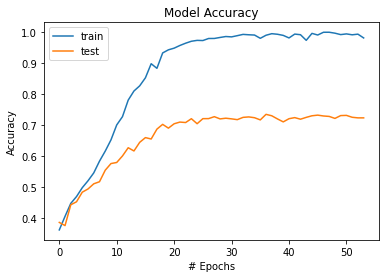

In [401]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('# Epochs')
plt.legend(['train', 'test'])
plt.show()

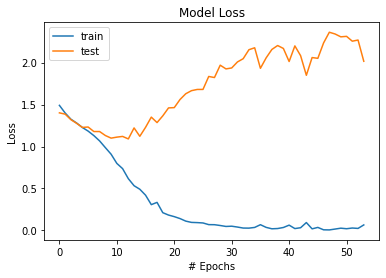

In [402]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('# Epochs')
plt.legend(['train', 'test'])
plt.show()

## Model Architecture

In [403]:
# load the saved model
from keras.models import load_model
model = load_model("./data/mpaa_classifier_n_sample_exceptNC17BiD.h5")

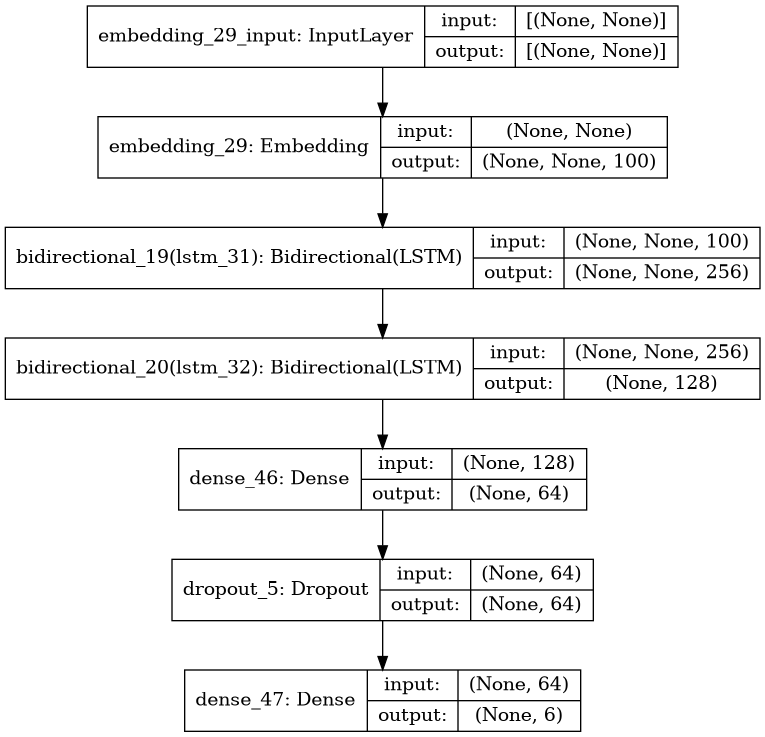

In [404]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Demonstration